In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kde
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erfinv
from matplotlib.colors import LogNorm

#settings
plt.style.use('classic')
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 3.0
matplotlib.rcParams['hist.bins'] = 'auto'
matplotlib.rcParams['image.cmap'] = 'RdYlBu_r' #'hot'
#print(matplotlib.rcParams)

print("Hello world!")
inputFile="../DataFiles/ACP80_0_p100k.dat"
inFileLabel=r"0 $\mu$rad"
inputSimFile="../DataFiles/ACP80_plus50_p100k.dat"
inSimFileLabel=r"+50 $\mu$rad"
cols=["gonio_angle","d0_x","d0_y","thetaIn_x","thetaOut_x","thetaIn_y","thetaOut_y","unknown1","unknown2"]

#Common offset for ACP80 runs
gonio_zero = 1570840.0/1000. #mrad

Hello world!


In [2]:
def emittanceRMSBis(x,y):
    return math.sqrt(np.mean(x*x)*np.mean(y*y) - np.mean(x*y)*np.mean(x*y))

def emittanceRMS(x,y):
    rmsX = np.std(x)
    rmsY = np.std(y)
    #print(np.corrcoef(x,y))
    det = np.linalg.det(np.corrcoef(x,y))
    #print(rmsX,rmsY,det)
    return rmsX*rmsY*math.sqrt(det)
    
def fracToSigma(f):
    return erfinv(f)*math.sqrt(2.)
def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
if inputSimFile == "":
    simu = data
else :
    simu = np.genfromtxt(inputSimFile,
                         names=cols,
                         dtype=None,
                         delimiter=',')

datasetI = pd.read_csv(inputFile,header=None,names=cols)
datasetI["gonio_angle"]=datasetI["gonio_angle"]/1000.
datasetI["thetaIn_x"]=datasetI["thetaIn_x"]*1000.
datasetI["thetaOut_x"]=datasetI["thetaOut_x"]*1000.
datasetI["thetaIn_y"]=datasetI["thetaIn_y"]*1000.
datasetI["thetaOut_y"]=datasetI["thetaOut_y"]*1000.
datasetI["deltaTheta"] = datasetI["thetaOut_x"]-datasetI["thetaIn_x"]
print(datasetI.iloc[0,:])

if inputSimFile == "":
    datasetSimuI = datasetI
else :
    datasetSimuI = pd.read_csv(inputSimFile,header=None,names=cols)
    datasetSimuI["gonio_angle"]=datasetSimuI["gonio_angle"]/1000.
    datasetSimuI["thetaIn_x"]=datasetSimuI["thetaIn_x"]*1000.
    datasetSimuI["thetaOut_x"]=datasetSimuI["thetaOut_x"]*1000.
    datasetSimuI["thetaIn_y"]=datasetSimuI["thetaIn_y"]*1000.
    datasetSimuI["thetaOut_y"]=datasetSimuI["thetaOut_y"]*1000.
    datasetSimuI["deltaTheta"] = datasetSimuI["thetaOut_x"]-datasetI["thetaIn_x"]
print(datasetSimuI.iloc[0,:])

gonio_angle    1570.840000
d0_x             -3.350927
d0_y             -4.145363
thetaIn_x        -0.071660
thetaOut_x       -0.066953
thetaIn_y        -0.085815
thetaOut_y       -0.066987
unknown1          0.000000
unknown2          0.000000
deltaTheta        0.004707
Name: 0, dtype: float64
gonio_angle    1570.889900
d0_x             -0.537172
d0_y             -2.690703
thetaIn_x         0.036072
thetaOut_x        0.099224
thetaIn_y         0.033945
thetaOut_y        0.026639
unknown1          0.000000
unknown2          0.000000
deltaTheta        0.170884
Name: 0, dtype: float64


In [4]:
#pass the initial dataset to the one you'll manipulate
dataset = datasetI

#clean from zeros
dataset = dataset[dataset.d0_x != 0.0]
dataset = dataset[dataset.d0_y != 0.0]

#define weights
dataset["weight"] = 1.

#pass the initial dataset to the one you'll manipulate
datasetSimu = datasetSimuI

#clean from zeros
datasetSimu = datasetSimu[datasetSimu.d0_x != 0.0]
datasetSimu = datasetSimu[datasetSimu.d0_y != 0.0]

#define weights
datasetSimu["weight"] = 1.

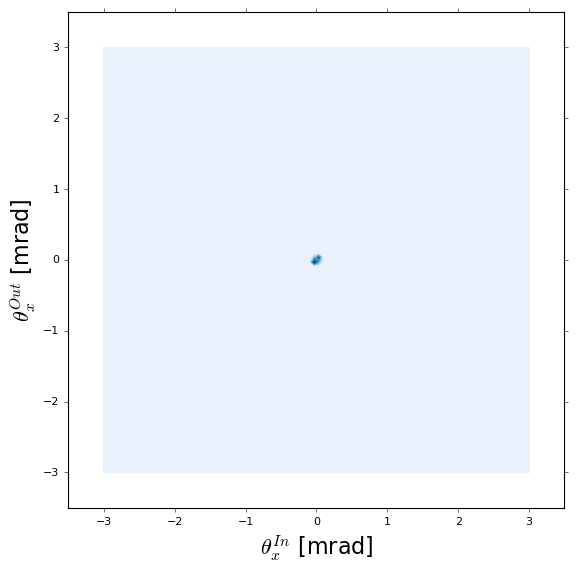

In [5]:
nbins=100
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

ax = plt.subplot(1,1,1)
#plt.scatter(dataset["thetaIn_x"],dataset["thetaOut_x"],marker=None)
#plt.scatter(datasetSimu["thetaIn_x"],datasetSimu["thetaOut_x"],marker=None)
k = kde.gaussian_kde([dataset["thetaIn_x"],dataset["thetaOut_x"]])
xi, yi = np.mgrid[-3.:3.:nbins*1j, (-3.):(3.):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
CF = ax.contourf(xi, yi,
                zi.reshape(xi.shape),
                cmap='Blues'
                )
plt.xlim(-3.5/1000, 3.5/1000)
plt.ylim(-3.5/1000, 3.5/1000)
plt.xlabel(r"$\theta^{In}_x$ [mrad]",fontsize='20')
plt.ylabel(r"$\theta^{Out}_x$ [mrad]",fontsize='20')
plt.show()


In [6]:
applyCut = True
applyWeight = False
max_d0x = 1.
max_d0y = 2.
max_thetaInx = 0.0005

if applyCut:
    #apply whatever selection you need
    dataset = dataset[abs(dataset.d0_x)<max_d0x]
    dataset = dataset[abs(dataset.d0_y)<max_d0y]
    dataset = dataset[abs(dataset.thetaIn_x)<max_thetaInx]


#pass the initial dataset to the one you'll manipulate
datasetSimu = datasetSimuI

if applyCut:
    #apply whatever selection you need
    datasetSimu = datasetSimu[abs(datasetSimu.d0_x)<max_d0x]
    datasetSimu = datasetSimu[abs(datasetSimu.d0_y)<max_d0y]
    datasetSimu = datasetSimu[abs(datasetSimu.thetaIn_x)<max_thetaInx]


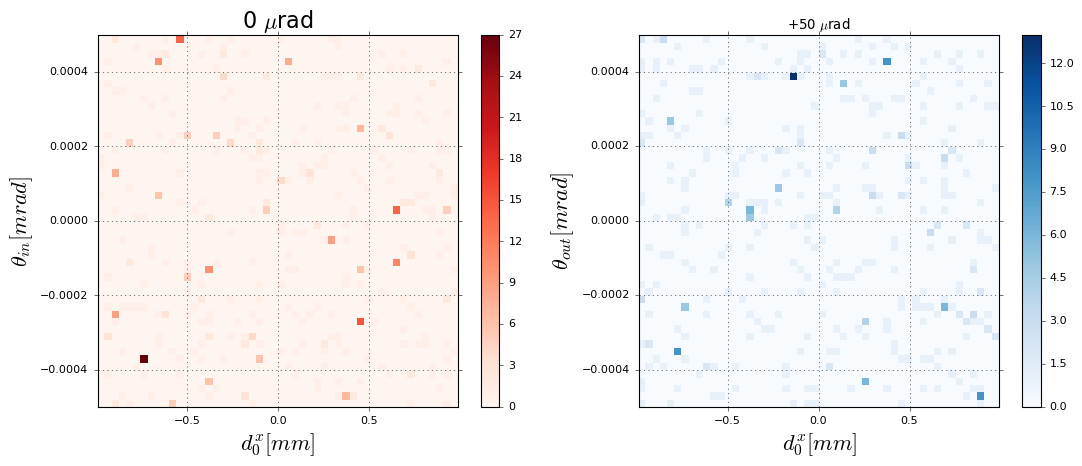

Emittance (RMS):  0.0001684537856460656  -  0.00017254152507027474


In [23]:
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w')
nbins=100

ax1 = plt.subplot(1,2,1)
plt.title(inFileLabel,fontsize=20)
plt.hist2d(dataset["d0_x"], dataset["thetaIn_x"], bins=(50, 50), cmap="Reds")
plt.xlabel(r"$d_{0}^{x} [mm]$",fontsize='20')
plt.ylabel(r"$\theta_{in} [mrad]$",fontsize='20')
plt.colorbar()
plt.grid(True)
#confidence_ellipse(dataset["d0_x"], dataset["thetaIn_x"], ax1, n_std=1.0, edgecolor='k')
#confidence_ellipse(dataset["d0_x"], dataset["thetaIn_x"], ax1, n_std=fracToSigma(0.9), edgecolor='green')


ax2 = plt.subplot(1,2,2)
plt.title(inSimFileLabel)
plt.hist2d(datasetSimu["d0_x"], datasetSimu["thetaIn_x"], bins=(50, 50), cmap="Blues")
plt.xlabel(r"$d_{0}^{x} [mm]$",fontsize='20')
plt.ylabel(r"$\theta_{in} [mrad]$",fontsize='20')
plt.colorbar()
plt.grid(True)
#confidence_ellipse(datasetSimu["d0_x"], datasetSimu["thetaIn_x"], ax2, n_std=1.0, edgecolor='k')
#confidence_ellipse(datasetSimu["d0_x"], datasetSimu["thetaIn_x"], ax2, n_std=fracToSigma(0.9), edgecolor='green')

plt.show()
print("Emittance (RMS): ",emittanceRMS(dataset["d0_x"],dataset["thetaIn_x"]),
    " - ",emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaIn_x"]))

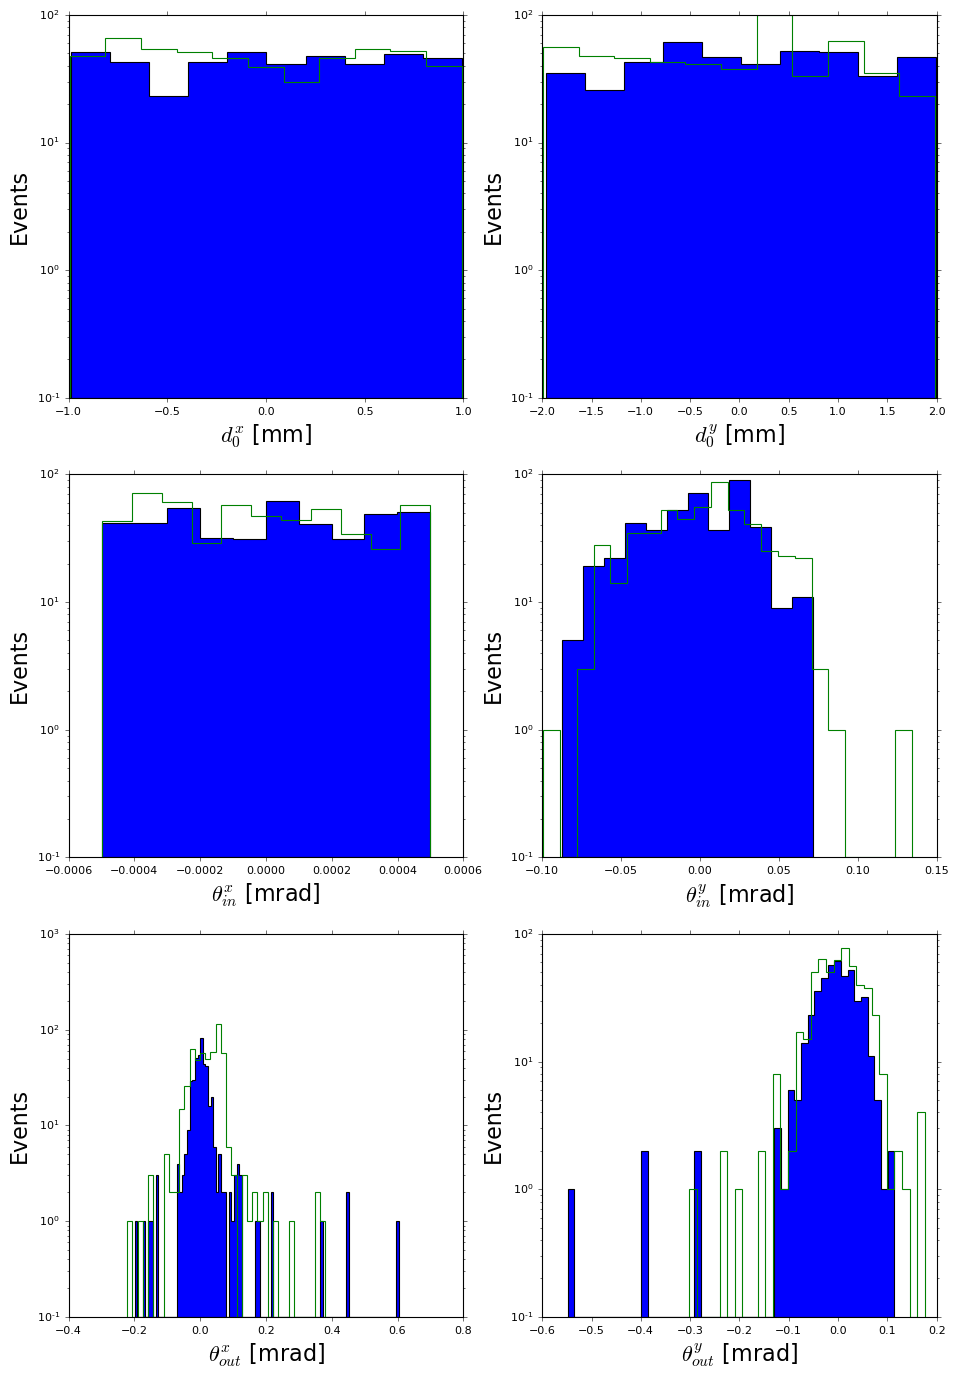

In [8]:
plt.figure(num=None, figsize=(14, 21), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3,2,1)
plt.xlabel(r"$d_0^{x}$ [mm]",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.hist(datasetSimu["d0_x"],log=True,histtype='stepfilled')
plt.hist(dataset["d0_x"],log=True,histtype='step', )

plt.subplot(3,2,2)
plt.xlabel(r"$d_0^{y}$ [mm]",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.hist(datasetSimu["d0_y"],log=True,histtype='stepfilled')
plt.hist(dataset["d0_y"],log=True,histtype='step')

plt.subplot(3,2,3)
plt.xlabel(r"$\theta_{in}^{x}$ [mrad]",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.hist(datasetSimu["thetaIn_x"],log=True,histtype='stepfilled')
plt.hist(dataset["thetaIn_x"],log=True,histtype='step')

plt.subplot(3,2,4)
plt.xlabel(r"$\theta_{in}^{y}$ [mrad]",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.hist(datasetSimu["thetaIn_y"],log=True,histtype='stepfilled')
plt.hist(dataset["thetaIn_y"],log=True,histtype='step')

plt.subplot(3,2,5)
plt.xlabel(r"$\theta_{out}^{x}$ [mrad]",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.hist(datasetSimu["thetaOut_x"],log=True,histtype='stepfilled')
plt.hist(dataset["thetaOut_x"],log=True,histtype='step')

plt.subplot(3,2,6)
plt.xlabel(r"$\theta_{out}^{y}$ [mrad]",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.hist(datasetSimu["thetaOut_y"],log=True,histtype='stepfilled')
plt.hist(dataset["thetaOut_y"],log=True,histtype='step')

plt.show()


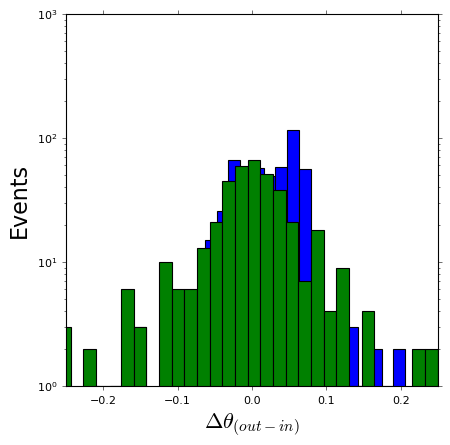

In [9]:

#plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
#plt.scatter(dataset["d0_x"],dataset["d0_y"],marker=None)
#plt.scatter(datasetSimu["d0_x"],datasetSimu["d0_y"],marker=None)
#plt.xlim(-3.5, 3.5)
#plt.ylim(-3.5, 3.5)
#plt.xlabel(r"$d_0^x$ [mm]",fontsize='20')
#plt.ylabel(r"$d_0^y$ [mm]",fontsize='20')
#plt.show()

plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(dataset["deltaTheta"],log=True)
plt.hist(datasetSimu["deltaTheta"],log=True)
plt.xlim(-0.25, 0.25)
plt.xlabel(r"$\Delta\theta_{(out-in)}$",fontsize='20')
plt.ylabel("Events",fontsize='20')
plt.show()


#plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
#plt.scatter(dataset["deltaTheta"],dataset["thetaIn_x"],marker=None)
#plt.scatter(datasetSimu["deltaTheta"],datasetSimu["thetaIn_x"],marker=None)
#plt.xlim(-0.25, 0.25)
#plt.ylim(-0.25, 0.25)
#plt.xlabel(r"$\Delta\theta_{(out-in)}$",fontsize='20')
#plt.ylabel(r"$\theta_{in}$",fontsize='20')
#plt.show()


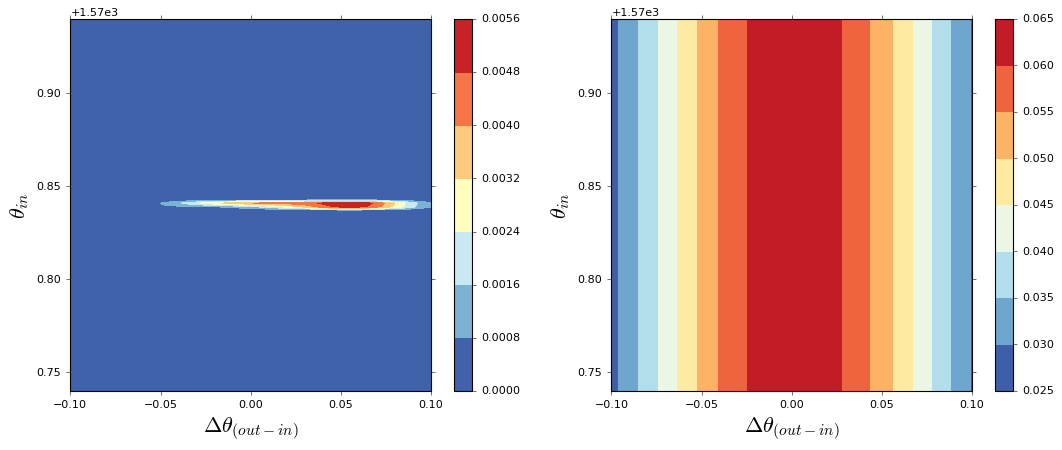

In [10]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
nbins=100

plt.subplot(1,2,1)
k = kde.gaussian_kde([dataset["deltaTheta"],dataset["thetaIn_x"]+dataset["gonio_angle"]])
xi, yi = np.mgrid[-0.1:0.1:nbins*1j, (-0.1+gonio_zero):(0.1+gonio_zero):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contourf(xi, yi, 
            zi.reshape(xi.shape)
            )
               #norm=LogNorm(1.E0,zi.max()))
plt.xlabel(r"$\Delta\theta_{(out-in)}$",fontsize='20')
plt.ylabel(r"$\theta_{in}$",fontsize='20')
plt.colorbar()

plt.subplot(1,2,2)
kS = kde.gaussian_kde([datasetSimu["deltaTheta"],datasetSimu["thetaIn_x"]+datasetSimu["gonio_angle"]])
xi, yi = np.mgrid[-0.1:0.1:nbins*1j, (-0.1+gonio_zero):(0.1+gonio_zero):nbins*1j]
zi = kS(np.vstack([xi.flatten(), yi.flatten()]))
plt.contourf(xi, yi, 
               zi.reshape(xi.shape)
            )
               #norm=LogNorm(1.E0,zi.max()))
plt.xlabel(r"$\Delta\theta_{(out-in)}$",fontsize='20')
plt.ylabel(r"$\theta_{in}$",fontsize='20')
plt.colorbar()


plt.show()

In [11]:
#mimic the presence of the septum
septumAng = 0.03
print(septumAng)
#print(dataset["thetaOut_x"])
#dataset = dataset[(dataset.thetaOut_x)>septumAng]
#print(dataset)

0.03


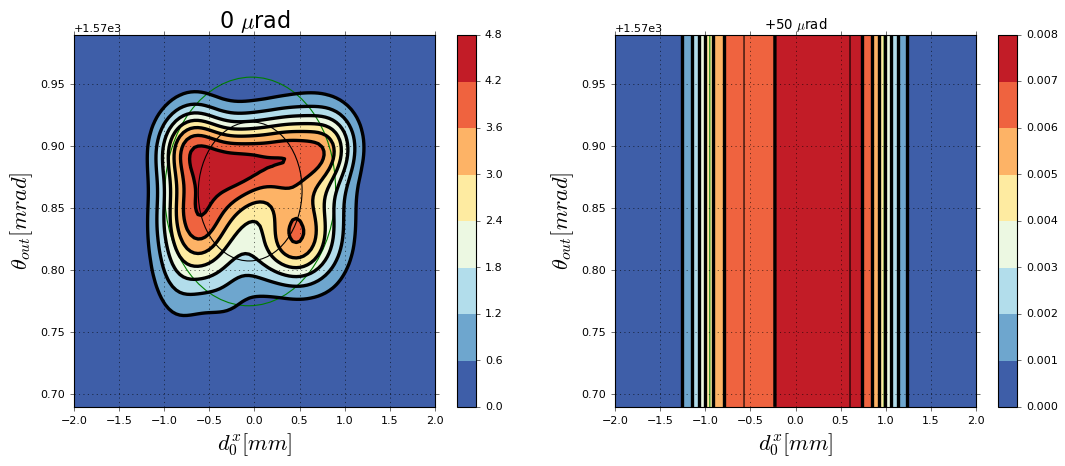

Emittance (RMS):  0.03219794745052902  -  44.13947452478584


In [12]:
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w')
nbins=100

ax1 = plt.subplot(1,2,1)
plt.title(inFileLabel,fontsize=20)
x = dataset["d0_x"]
y = dataset["thetaOut_x"]+dataset["gonio_angle"]
k = kde.gaussian_kde([dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"]])
xi, yi = np.mgrid[-2.:2.:nbins*1j, (-0.15+gonio_zero):(0.15+gonio_zero):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
CF1 = ax1.contourf(xi, yi, 
            zi.reshape(xi.shape)#,
#            cmap='Reds'
           )
CS1 = ax1.contour(xi, yi, 
            zi.reshape(xi.shape),
            colors='k'
           )
#            norm=LogNorm(1.E0,zi.max()))
plt.xlabel(r"$d_{0}^{x} [mm]$",fontsize='20')
plt.ylabel(r"$\theta_{out} [mrad]$",fontsize='20')
plt.colorbar(CF1)
plt.grid(True)
confidence_ellipse(dataset["d0_x"], dataset["thetaOut_x"]+dataset["gonio_angle"], ax1, n_std=1.0, edgecolor='k')
confidence_ellipse(dataset["d0_x"], dataset["thetaOut_x"]+dataset["gonio_angle"], ax1, n_std=fracToSigma(0.9), edgecolor='green')

ax2 = plt.subplot(1,2,2)
plt.title(inSimFileLabel)
x = dataset["d0_x"]
y = dataset["thetaOut_x"]+dataset["gonio_angle"]
k = kde.gaussian_kde([datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"]])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
xi, yi = np.mgrid[-2.:2.:nbins*1j, (-0.15+gonio_zero):(0.15+gonio_zero):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
CF2 = ax2.contourf(xi, yi,
                zi.reshape(xi.shape),
#                cmap='Blues'
                )
CS2 = ax2.contour(xi, yi,
                zi.reshape(xi.shape),
                colors='k'
                )
#            norm=LogNorm(1.E0,zi.max()))
#plt.clabel(CS2, inline=1, fontsize=10)
plt.xlabel(r"$d_{0}^{x} [mm]$",fontsize='20')
plt.ylabel(r"$\theta_{out} [mrad]$",fontsize='20')
plt.colorbar(CF2)
plt.grid(True)
confidence_ellipse(datasetSimu["d0_x"], datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"], ax2, n_std=1.0, edgecolor='k')
confidence_ellipse(datasetSimu["d0_x"], datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"], ax2, n_std=fracToSigma(0.9), edgecolor='green')
plt.show()

print("Emittance (RMS): ",emittanceRMS(dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"]),
    " - ",emittanceRMS(datasetSimu["d0_x"],datasetSimu["thetaOut_x"]+datasetSimu["gonio_angle"]))

fig.savefig("beams.pdf")

In [13]:
print(emittanceRMS(dataset["d0_x"],dataset["thetaOut_x"]+dataset["gonio_angle"]))

0.03219794745052902


In [14]:
from scipy import stats
stats.scoreatpercentile(zi,[32,10,5])

array([3.18681939e-04, 5.06727596e-07, 8.01626327e-08])

In [15]:
#rought RMS emittance calculation
emittance = math.sqrt(np.mean(dataset["d0_x"])*np.mean(dataset["thetaOut_x"]+dataset["gonio_angle"])-np.mean(dataset["d0_x"])*np.mean(dataset["thetaOut_x"]+dataset["gonio_angle"]))
print(emittance)

0.0
